In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras
import keras
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers

# Tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Custom imports
from physionet_processing import (fetch_h5data, spectrogram, 
                                  special_parameters, transformed_stats)

from physionet_generator import DataGenerator

print('Tensorflow version:', tf.__version__)
print('Keras version:', keras.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6952427457894928550
xla_global_id: -1
]
Tensorflow version: 2.9.2
Keras version: 2.9.0


In [2]:
# Data folder and hdf5 dataset file
data_root = os.path.normpath('.')
#data_root = os.path.normpath('/media/sf_vbshare/physionet_data/')
#data_root = os.path.normpath('/home/ubuntu/projects/csproject')
# hd_file = os.path.join(data_root, 'physio.h5')
hd_file = "/Users/macbookpro/Documents/physio.h5"
label_file = '/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/REFERENCE-v3.csv'

# Open hdf5 file
h5file =  h5py.File(hd_file, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

# Load the labels
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
# Filter the labels that are in the small demo set
label_df = label_df[label_df['name'].isin(dataset_list)]

# Encode labels to integer numbers
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

In [3]:
#parameters 
# Maximum sequence length
max_length = 18286

# Output dimensions
sequence_length = max_length
spectrogram_nperseg = 64 # Spectrogram window
spectrogram_noverlap = 32 # Spectrogram overlap
n_classes = len(label_df.label.unique())
batch_size = 32


def get_sample():
    # Pick one ECG randomly from each class 
    df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
    df_set = list(df.label.unique())
    fid_list = [np.random.choice(df[df.label == label].name.values, 1)[0] for label in df_set]
    return fid_list

name_list = get_sample()
idx_list = [dataset_list.index(name) for name in name_list]

data = fetch_h5data(h5file, idx_list, sequence_length)
_, _, Sxx = spectrogram(data, nperseg = spectrogram_nperseg, noverlap = spectrogram_noverlap)
dim = Sxx[0].shape

In [4]:
params = {'batch_size': batch_size,
            'dim': dim,
            'nperseg': spectrogram_nperseg,
            'noverlap': spectrogram_noverlap,
            'n_channels': 1,
            'sequence_length': sequence_length,
            'n_classes': n_classes,
            'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)


In [16]:
import csv 
for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)

outfile = "/Users/macbookpro/Documents/ptb_xl/array_passing_test/X_data.txt"
np.set_printoptions(suppress=True)

print(X[0].shape)
# np.savetxt(outfile,X[0],delimiter =",", fmt ='%f')


with open(outfile, 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)

    write.writerow(X[0].flatten().tolist())


X shape: (32, 570, 33)
y shape: (32, 4)
(570, 33)


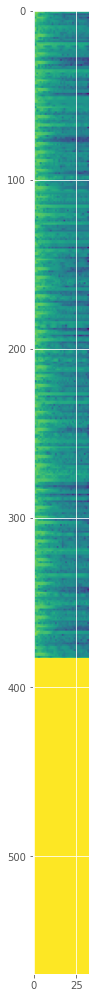

In [6]:
plt.figure(figsize=(1,50))
plt.imshow(X[0].reshape(570,-1))
plt.show()